In [21]:
# BIBLIOTECAS
import os
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from astropy.visualization import PercentileInterval, AsinhStretch
import pandas as pd

In [22]:
#LEITURA SEM FILTRAGEM

def ler_arquivos_fits(pasta):
    dados = []
    nomes_arquivos = []
    arquivos_totais = 0
    arquivos_carregados = 0
    
    for nome_arquivo in sorted(os.listdir(pasta)):  # Ordena para manter uma ordem fixa
        if nome_arquivo.endswith('.fits'):  # Verifica se o arquivo é .fits
            arquivos_totais += 1
            caminho_arquivo = os.path.join(pasta, nome_arquivo)
            try:
                with fits.open(caminho_arquivo) as hdul:
                    if hdul[0].data is not None:  # Verifica se há dados
                        dados.append(hdul[0].data)
                        nomes_arquivos.append(nome_arquivo)
                        arquivos_carregados += 1
                    else:
                        print(f"Aviso: {nome_arquivo} não contém dados.")
            except Exception as e:
                print(f"Erro ao abrir {nome_arquivo}: {e}")
    
    print(f"Lidos {arquivos_totais} arquivos FITS totais, sendo {arquivos_carregados} carregados com sucesso.")
    return np.array(dados), nomes_arquivos  # Retorna dados e nomes

# Caminho da pasta
pasta = './ima_r'

# Carregar todos os arquivos FITS da pasta
dados, nomes_arquivos = ler_arquivos_fits(pasta)

Lidos 4458 arquivos FITS totais, sendo 4458 carregados com sucesso.


In [42]:
#LEITURA COM FILTRAGEM

def ler_arquivos_fits(pasta, lista_filtros):
    dados = []
    nomes_arquivos = []
    arquivos_totais = 0
    arquivos_filtrados = 0
    
    for nome_arquivo in sorted(os.listdir(pasta)):  # Ordena para manter uma ordem fixa
        if nome_arquivo.endswith('.fits'):
            arquivos_totais += 1
            nome_base = nome_arquivo.replace('_r.fits', '')  # Remove a extensão para comparar
            
            if nome_base in lista_filtros:  # Filtra pelos arquivos da lista
                caminho_arquivo = os.path.join(pasta, nome_arquivo)
                try:
                    with fits.open(caminho_arquivo) as hdul:
                        if hdul[0].data is not None:  # Verifica se há dados
                            dados.append(hdul[0].data)
                            nomes_arquivos.append(nome_arquivo)
                            arquivos_filtrados += 1
                        else:
                            print(f"Aviso: {nome_arquivo} não contém dados.")
                except Exception as e:
                    print(f"Erro ao abrir {nome_arquivo}: {e}")
    
    print(f"Lidos {arquivos_totais} arquivos FITS totais, sendo {arquivos_filtrados} que atendem aos critérios de filtragem.")
    return np.array(dados), nomes_arquivos  # Retorna dados e nomes

def carregar_lista_filtros(lista_path):
    try:
        with open(lista_path, 'r') as f:
            lista_filtros = {linha.strip() for linha in f}  # Conjunto para busca rápida
        return lista_filtros
    except Exception as e:
        print(f"Erro ao carregar a lista de filtros: {e}")
        return set()

# Caminhos dos arquivos
pasta = './ima_r'
lista_filtros_path = './listaT_T9.txt'
lista_filtros = carregar_lista_filtros(lista_filtros_path)

dados, nomes_arquivos = ler_arquivos_fits(pasta, lista_filtros)


Lidos 4458 arquivos FITS totais, sendo 263 que atendem aos critérios de filtragem.


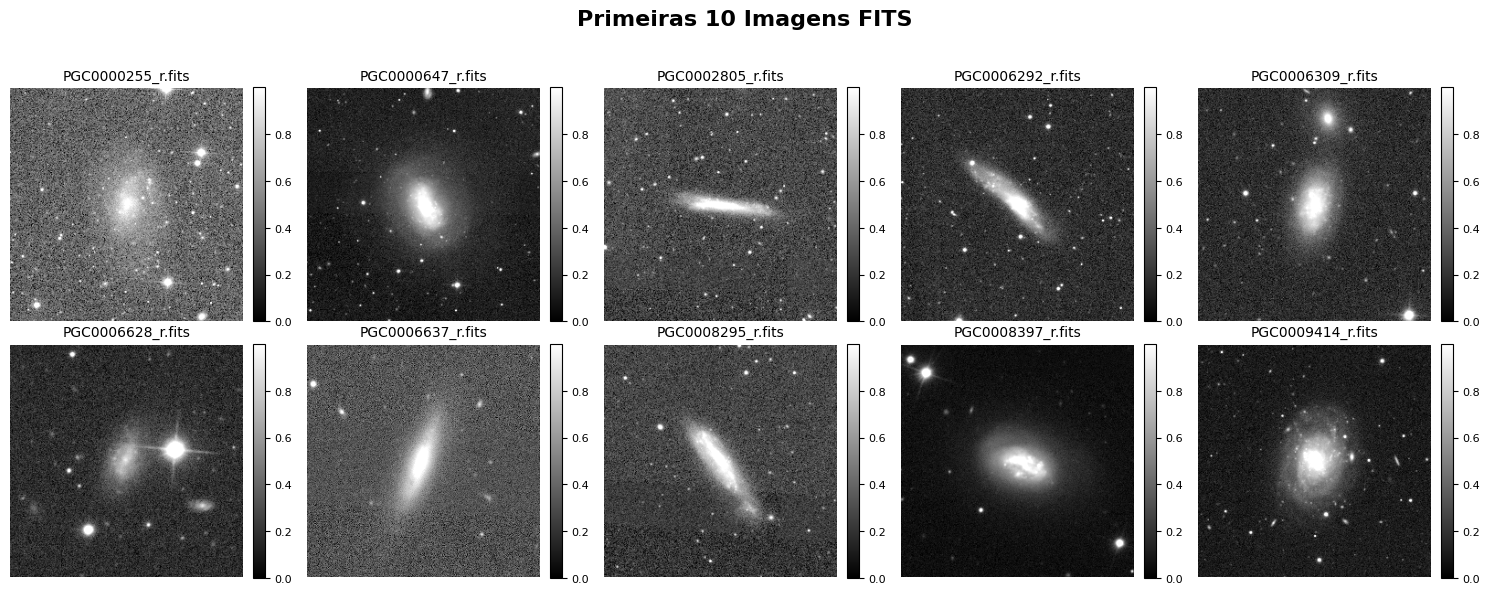

In [47]:
# PLOTAR AS 10 PRIMEIRAS IMAGENS COM ESCALA DE PIXEL
fig, axes = plt.subplots(2, 5, figsize=(15, 6))  # Layout 2x5
fig.suptitle('Primeiras 10 Imagens FITS', fontsize=16, fontweight='bold')

# Normalizador para melhorar a visualização (evita imagens muito escuras)
interval = PercentileInterval(99)  # Define um intervalo de percentil para normalização
stretch = AsinhStretch()  # Escala para evitar saturação

for i, ax in enumerate(axes.flat):
    if i < len(dados):  # Garante que há imagens suficientes
        img_normalizada = stretch(interval(dados[i]))  # Aplica normalização
        im = ax.imshow(img_normalizada, cmap='gray', origin='lower')  # Exibe em escala de cinza
        ax.set_title(nomes_arquivos[i], fontsize=10)  # Exibe o nome do arquivo
        ax.axis('off')  # Remove eixos para ficar mais limpo
        
        # Adiciona barra de escala (colorbar)
        cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
        cbar.ax.tick_params(labelsize=8)  # Ajusta tamanho da fonte da escala

plt.tight_layout(rect=[0, 0, 1, 0.95])  # Ajusta layout
plt.show()


In [48]:
# PRÉ-PROCESSAMENTO: NORMALIZAÇÃO DOS DADOS
def normalizar_dados(dados):
    eps = 1e-8  # Pequeno valor para evitar divisão por zero
    return (dados - np.min(dados)) / (np.max(dados) - np.min(dados) + eps)

dados = normalizar_dados(dados)


In [54]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA

# Função para aplicar PCA
def aplicar_pca(dados, n_componentes):
    # Redimensionar os dados para 2D (amostras, características)
    n_amostras, altura, largura = dados.shape
    dados_2d = dados.reshape(n_amostras, -1)
    
    # Aplicar PCA
    pca = PCA(n_components=n_componentes)
    componentes_principais = pca.fit_transform(dados_2d)
    
    return componentes_principais, pca, altura, largura

# Ler a lista completa
lista_completa_path = "listacompleta.txt"
df_lista = pd.read_csv(lista_completa_path, delim_whitespace=True)

# Separar os valores únicos de T
valores_T = df_lista["T"].unique()

# Número de componentes principais
n_componentes = 30

# Dicionário para armazenar os resultados do PCA por classe T
resultados_pca = {}

for t in valores_T:
    # Filtrar os nomes das galáxias com esse valor de T
    nomes_galaxias = df_lista[df_lista["T"] == t]["PGCname"].values

    # Aqui, supondo que exista uma função que carregue as imagens associadas a essas galáxias
    dados = carregar_imagens(nomes_galaxias)  # Essa função deve ser definida

    if dados is not None and len(dados) > 0:
        # Aplicar PCA para a classe T específica
        componentes_principais, pca, altura, largura = aplicar_pca(dados, n_componentes)

        # Armazenar os resultados
        resultados_pca[t] = componentes_principais

        print(f"PCA aplicado para T = {t}. Shape: {componentes_principais.shape}")
    else:
        print(f"Sem dados para T = {t}, PCA não aplicado.")

# Se necessário, salvar os resultados
for t, componentes in resultados_pca.items():
    np.savetxt(f"PCA_T{t}.txt", componentes, delimiter="\t")
    print(f"Resultados de PCA para T = {t} salvos em 'PCA_T{t}.txt'.")


/tmp/ipykernel_12923/4151954403.py:19: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df_lista = pd.read_csv(lista_completa_path, delim_whitespace=True)


NameError: name 'carregar_imagens' is not defined

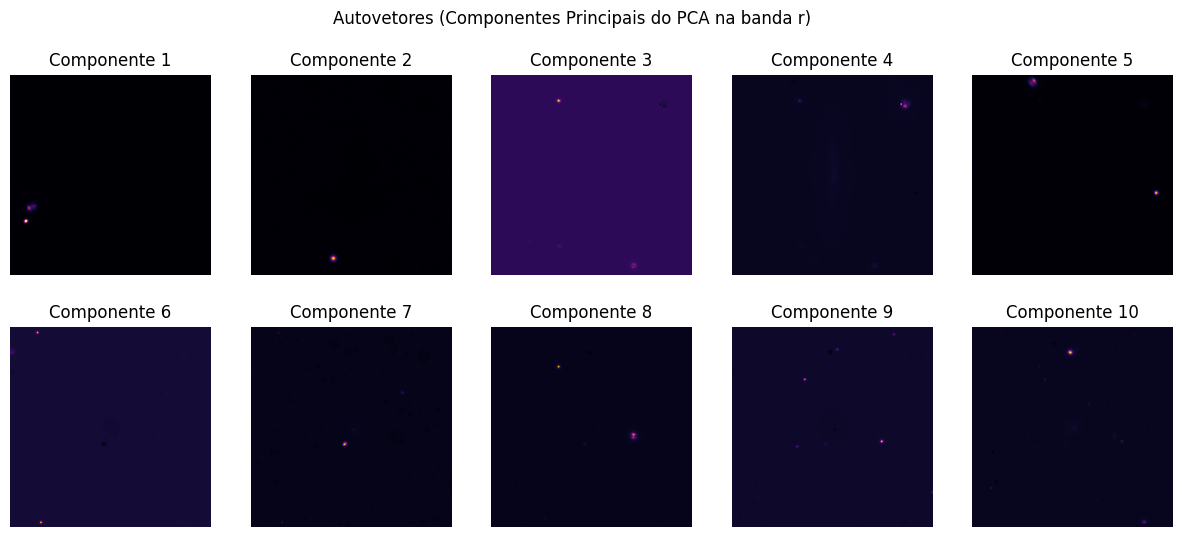

In [50]:
#PLOT: Autovetores (componentes principais) como imagens
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
fig.suptitle("Autovetores (Componentes Principais do PCA na banda r)")

for i, ax in enumerate(axes.flat):
    autovetor = pca.components_[i].reshape(altura, largura)  # Redimensiona para formato original
    ax.imshow(autovetor, cmap='inferno')
    ax.set_title(f"Componente {i+1}")
    ax.axis("off")

plt.show()


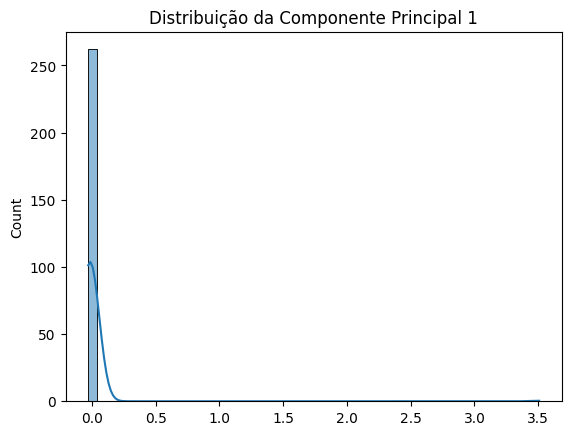

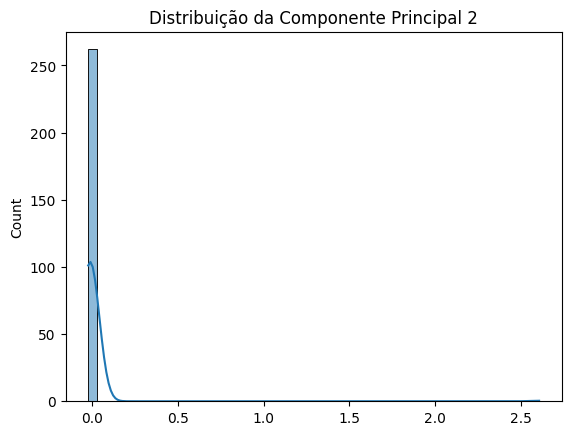

In [51]:
import seaborn as sns
sns.histplot(componentes_principais[:, 0], bins=50, kde=True)
plt.title('Distribuição da Componente Principal 1')
plt.show()

sns.histplot(componentes_principais[:, 1], bins=50, kde=True)
plt.title('Distribuição da Componente Principal 2')
plt.show()

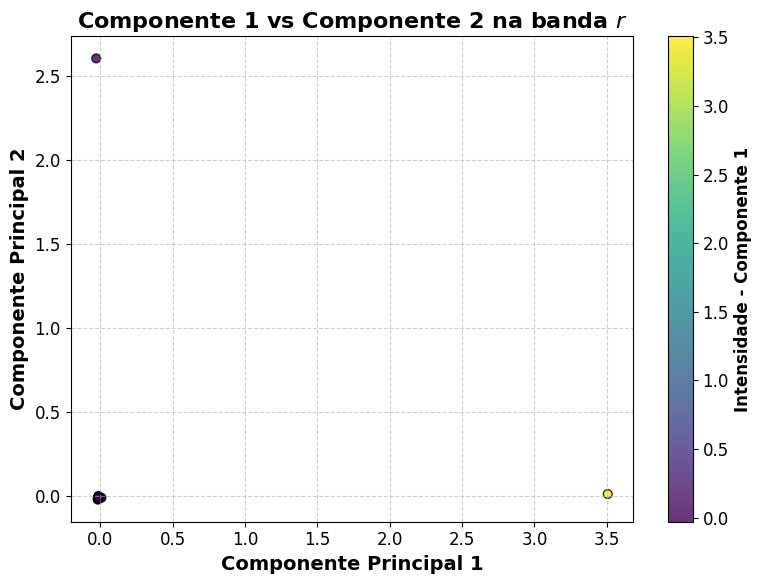

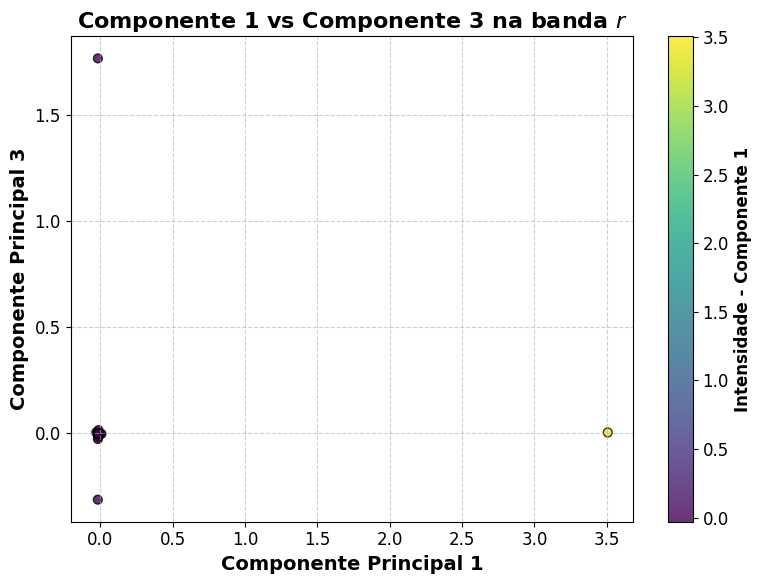

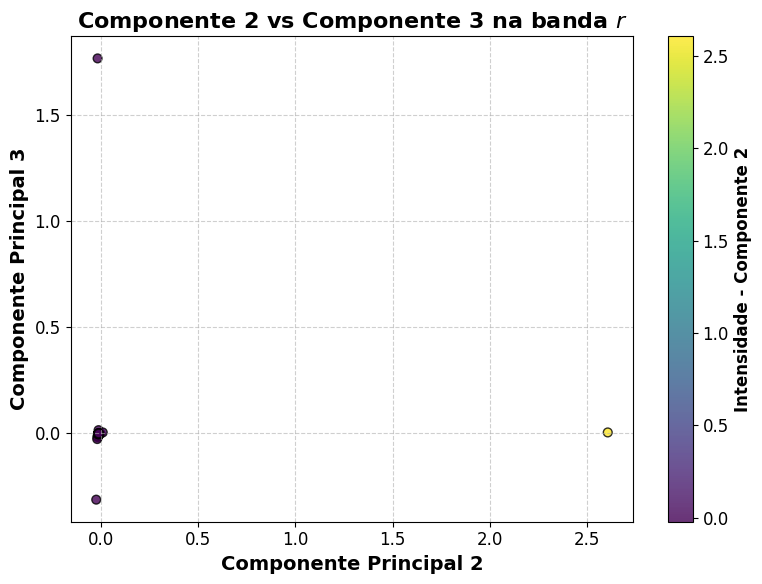

In [52]:
import matplotlib.pyplot as plt
import numpy as np

# Definir estilo global para os gráficos (padrão para artigos científicos)
plt.style.use('default')  # Usa o estilo padrão do Matplotlib
plt.rcParams.update({
    'font.size': 12,  # Tamanho da fonte
    'axes.labelsize': 14,  # Tamanho dos rótulos dos eixos
    'axes.titlesize': 16,  # Tamanho do título
    'xtick.labelsize': 12,  # Tamanho dos rótulos do eixo x
    'ytick.labelsize': 12,  # Tamanho dos rótulos do eixo y
    'axes.grid': True,  # Ativa a grade
    'grid.linestyle': '--',  # Estilo da linha da grade
    'grid.alpha': 0.6,  # Transparência da grade
    'figure.figsize': (8, 6),  # Tamanho da figura
    'lines.linewidth': 2,  # Espessura das linhas
    'axes.titleweight': 'bold',  # Título em negrito
    'axes.labelweight': 'bold',  # Rótulos dos eixos em negrito
})

# Tamanho dos pontos no scatter plot
point_size = 40

# Gráfico: Componente 1 vs Componente 2
plt.figure()
scatter = plt.scatter(componentes_principais[:, 0], componentes_principais[:, 1], 
                      c=componentes_principais[:, 0], cmap='viridis', alpha=0.8, s=point_size, edgecolors='k')
cbar = plt.colorbar(scatter)
cbar.set_label('Intensidade - Componente 1', fontsize=12, fontweight='bold')
plt.xlabel('Componente Principal 1', fontsize=14, fontweight='bold')
plt.ylabel('Componente Principal 2', fontsize=14, fontweight='bold')
plt.title('Componente 1 vs Componente 2 na banda $r$', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('componente1_vs_componente2_banda-r.png', dpi=300, bbox_inches='tight')  # Salva a figura em alta resolução
plt.show()

# Gráfico: Componente 1 vs Componente 3
plt.figure()
scatter = plt.scatter(componentes_principais[:, 0], componentes_principais[:, 2], 
                      c=componentes_principais[:, 0], cmap='viridis', alpha=0.8, s=point_size, edgecolors='k')
cbar = plt.colorbar(scatter)
cbar.set_label('Intensidade - Componente 1', fontsize=12, fontweight='bold')
plt.xlabel('Componente Principal 1', fontsize=14, fontweight='bold')
plt.ylabel('Componente Principal 3', fontsize=14, fontweight='bold')
plt.title('Componente 1 vs Componente 3 na banda $r$', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('componente1_vs_componente3_banda-r.png', dpi=300, bbox_inches='tight')  # Salva a figura em alta resolução
plt.show()

# Gráfico: Componente 2 vs Componente 3
plt.figure()
scatter = plt.scatter(componentes_principais[:, 1], componentes_principais[:, 2], 
                      c=componentes_principais[:, 1], cmap='viridis', alpha=0.8, s=point_size, edgecolors='k')
cbar = plt.colorbar(scatter)
cbar.set_label('Intensidade - Componente 2', fontsize=12, fontweight='bold')
plt.xlabel('Componente Principal 2', fontsize=14, fontweight='bold')
plt.ylabel('Componente Principal 3', fontsize=14, fontweight='bold')
plt.title('Componente 2 vs Componente 3 na banda $r$', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('componente2_vs_componente3_banda-r.png', dpi=300, bbox_inches='tight')  # Salva a figura em alta resolução
plt.show()

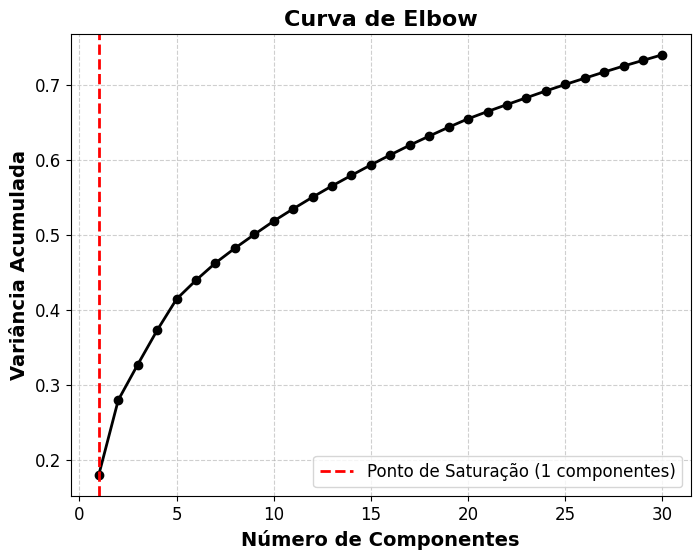

Proporção de variância explicada: [0.18018465 0.0994931  0.04722092 0.04574479 0.04164077 0.02509833
 0.02298121 0.0196384  0.01837646 0.0178499  0.01627772 0.01563931
 0.01492495 0.01411256 0.01389585 0.01336347 0.01292088 0.01211299
 0.01181285 0.01124898 0.0096808  0.00922959 0.00912637 0.00903421
 0.0086433  0.00833363 0.00825099 0.00798773 0.00754479 0.00751936]


In [53]:
# Variância explicada por cada componente
variancias_explicadas = pca.explained_variance_ratio_
variancia_acumulada = np.cumsum(variancias_explicadas)

# Encontrar o ponto de saturação (cotovelo)
threshold = 0.90
ponto_saturacao = np.argmax(variancia_acumulada >= threshold) + 1

# Plotar a Curva de Elbow
plt.figure()
plt.plot(range(1, len(variancia_acumulada) + 1), variancia_acumulada, color='black', marker='o', linestyle='-')
plt.axvline(x=ponto_saturacao, color='red', linestyle='--', label=f'Ponto de Saturação ({ponto_saturacao} componentes)')
plt.xlabel('Número de Componentes')
plt.ylabel('Variância Acumulada')
plt.title('Curva de Elbow')
plt.legend()
plt.grid(True)
plt.savefig('curva_elbow.png', dpi=300, bbox_inches='tight')
plt.show()

# Imprimir a proporção de variância explicada
print("Proporção de variância explicada:", variancias_explicadas)
